In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from ipywidgets import interact, fixed, IntSlider, Checkbox
from pathlib import Path
# Instalamos el paquete de utilidades
%pip install -qq git+https://github.com/udesa-vision/i308-utils.git

from i308_utils import imshow, show_images
from utils import rectify_stereo_pair, draw_epipolar_lines, show_pair_any, compute_depth

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Cargamos los archivos y analizamos el contenido
with open('data/pkls/stereo_calibration.pkl', 'rb') as f:
    calib = pickle.load(f)

with open('data/pkls/stereo_maps.pkl', 'rb') as f:
    maps = pickle.load(f)

print('Calibration keys:', calib.keys())
print('Maps keys:', maps.keys())

Calibration keys: dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size'])
Maps keys: dict_keys(['left_map_x', 'left_map_y', 'right_map_x', 'right_map_y', 'R1', 'R2', 'P1', 'P2', 'Q', 'validRoi1', 'validRoi2'])


Pares rectificados: 20


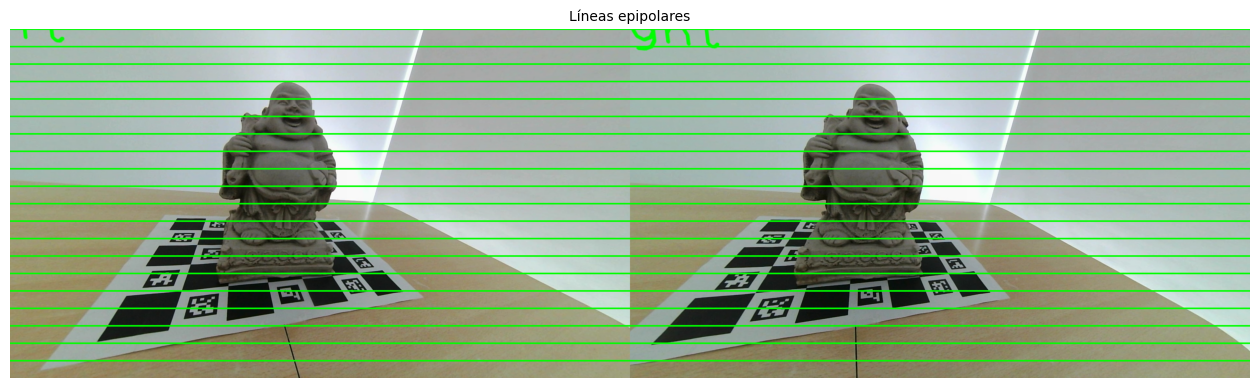

In [ ]:
    # Rectificamos los pares estéreo
    in_dir = Path('data/stereo_budha_charuco/captures')
    out_dir = Path('data/stereo_budha_charuco/rectified')
    out_dir.mkdir(exist_ok=True)

    indices = list(range(0, 20))

    procesados = 0
    faltantes = []

    for i in indices:
        left_path = in_dir / f'left_{i}.jpg'
        right_path = in_dir / f'right_{i}.jpg'
        if not left_path.exists() or not right_path.exists():
            faltantes.append(i)
            continue

        rectL, rectR = rectify_stereo_pair(str(left_path), str(right_path), maps)

        # Guardar
        cv2.imwrite(str(out_dir / f'rect_left_{i}.jpg'), rectL)
        cv2.imwrite(str(out_dir / f'rect_right_{i}.jpg'), rectR)
        procesados += 1

    print(f'Pares rectificados: {procesados}')
    if faltantes:
        print('Índices faltantes:', faltantes)

    # Visualizamos un par de imágenes rectificadas con líneas epipolares
    combinados = draw_epipolar_lines(rectL, rectR)
    imshow(combinados, title='Líneas epipolares', figsize=(16, 8))

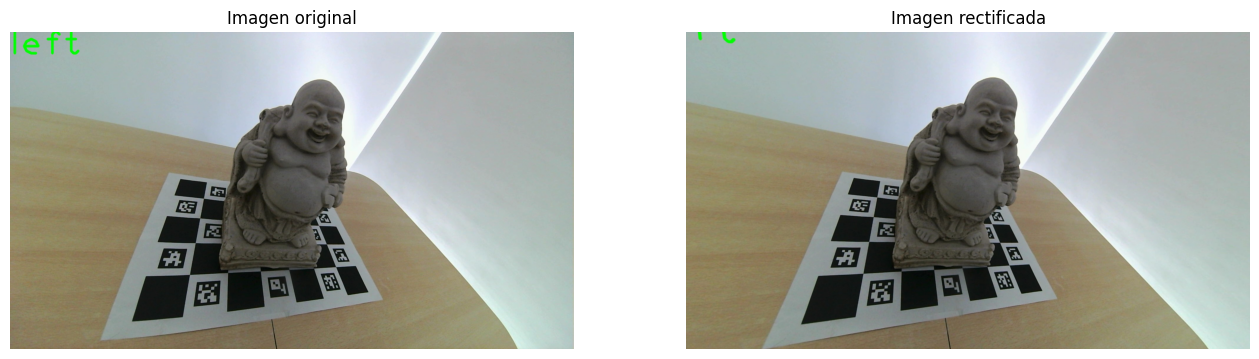

In [4]:
imgL = cv2.imread('data/stereo_budha_charuco/captures/left_0.jpg')
rectifiedL = cv2.remap(imgL, maps['left_map_x'], maps['left_map_y'], cv2.INTER_LINEAR)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Imagen original')
plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Imagen rectificada')
plt.imshow(cv2.cvtColor(rectifiedL, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## Cálculo de Disparidad
### Block Matching

In [5]:
from pathlib import Path

# Crear carpeta de salida (si no existe)
out_dir = Path("../out/disparities_bm")
out_dir.mkdir(exist_ok=True)

# Rango de índices (ajustá si tus nombres empiezan en otro número)
indices = range(0, 20)

for i in indices:
    left_path  = f"data/stereo_budha_charuco/captures/left_{i}.jpg"
    right_path = f"data/stereo_budha_charuco/captures/right_{i}.jpg"
    if not Path(left_path).exists() or not Path(right_path).exists():
        print(f"Saltando par {i}: faltan imágenes.")
        continue

    # Rectificación (usando tu función)
    rectL, rectR = rectify_stereo_pair(left_path, right_path, maps)

    # Pasar a escala de grises
    rectL_gray = cv2.cvtColor(rectL, cv2.COLOR_BGR2GRAY)
    rectR_gray = cv2.cvtColor(rectR, cv2.COLOR_BGR2GRAY)

    # Configurar el StereoBM
    stereo_bm = cv2.StereoBM_create(numDisparities=256, blockSize=15)
    stereo_bm.setPreFilterSize(31)
    stereo_bm.setPreFilterCap(15)
    stereo_bm.setMinDisparity(0)
    stereo_bm.setTextureThreshold(7)
    stereo_bm.setUniquenessRatio(3)
    stereo_bm.setSpeckleWindowSize(512)
    stereo_bm.setSpeckleRange(32)
    stereo_bm.setDisp12MaxDiff(23)

    # Calcular mapa de disparidad
    disparity_map_bm = stereo_bm.compute(rectL_gray, rectR_gray).astype(np.float32) / 16.0

    # Guardar disparidad normalizada para visualización
    disp_vis = cv2.normalize(disparity_map_bm, None, 0, 255, cv2.NORM_MINMAX)
    disp_vis = np.uint8(disp_vis)
    cv2.imwrite(str(out_dir / f"disp_bm_{i}.png"), disp_vis)

    print(f"→ Procesado par {i}: disparidad guardada en {out_dir}/disp_bm_{i}.png")


→ Procesado par 0: disparidad guardada en ..\out\disparities_bm/disp_bm_0.png
→ Procesado par 1: disparidad guardada en ..\out\disparities_bm/disp_bm_1.png
→ Procesado par 2: disparidad guardada en ..\out\disparities_bm/disp_bm_2.png
→ Procesado par 3: disparidad guardada en ..\out\disparities_bm/disp_bm_3.png
→ Procesado par 4: disparidad guardada en ..\out\disparities_bm/disp_bm_4.png
→ Procesado par 5: disparidad guardada en ..\out\disparities_bm/disp_bm_5.png
→ Procesado par 6: disparidad guardada en ..\out\disparities_bm/disp_bm_6.png
→ Procesado par 7: disparidad guardada en ..\out\disparities_bm/disp_bm_7.png
→ Procesado par 8: disparidad guardada en ..\out\disparities_bm/disp_bm_8.png
→ Procesado par 9: disparidad guardada en ..\out\disparities_bm/disp_bm_9.png
→ Procesado par 10: disparidad guardada en ..\out\disparities_bm/disp_bm_10.png
→ Procesado par 11: disparidad guardada en ..\out\disparities_bm/disp_bm_11.png
→ Procesado par 12: disparidad guardada en ..\out\disparitie

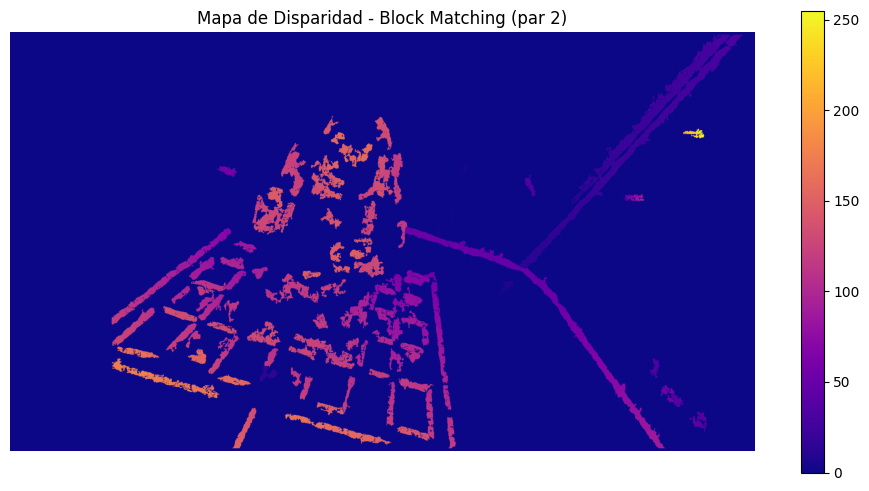

In [6]:
# Mostrar uno de ejemplo
idx_show = 2
disp_show = cv2.imread(str(out_dir / f"disp_bm_{idx_show}.png"), cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12,6))
plt.imshow(disp_show, cmap='plasma')
plt.colorbar()
plt.title(f'Mapa de Disparidad - Block Matching (par {idx_show})')
plt.axis('off')
plt.show()

### Semi-Global Block Matching

In [7]:
# Carpeta de salida
out_dir = Path("../out/disparities_sgbm")
out_dir.mkdir(exist_ok=True)

# Rango de imágenes 
indices = range(0, 20)

for i in indices:
    left_path  = f"data/stereo_budha_charuco/captures/left_{i}.jpg"
    right_path = f"data/stereo_budha_charuco/captures/right_{i}.jpg"
    if not Path(left_path).exists() or not Path(right_path).exists():
        print(f"Saltando par {i}: faltan imágenes.")
        continue

    # Rectificación estéreo
    rectL, rectR = rectify_stereo_pair(left_path, right_path, maps)

    # Pasar a escala de grises
    rectL_gray = cv2.cvtColor(rectL, cv2.COLOR_BGR2GRAY)
    rectR_gray = cv2.cvtColor(rectR, cv2.COLOR_BGR2GRAY)

    # --- Configuración StereoSGBM (con tus parámetros) ---
    stereo_sgbm = cv2.StereoSGBM_create(
        numDisparities=128,
        blockSize=7
    )

    stereo_sgbm.setP1(16)
    stereo_sgbm.setP2(128)
    stereo_sgbm.setUniquenessRatio(7)
    stereo_sgbm.setSpeckleWindowSize(512)
    stereo_sgbm.setSpeckleRange(64)
    stereo_sgbm.setDisp12MaxDiff(1)
    stereo_sgbm.setPreFilterCap(63)

    # --- Calcular disparidad ---
    disparity_map = stereo_sgbm.compute(rectL_gray, rectR_gray).astype(np.float32) / 16.0

    # --- Guardar mapa normalizado ---
    disp_vis = cv2.normalize(disparity_map, None, 0, 255, cv2.NORM_MINMAX)
    disp_vis = np.uint8(disp_vis)
    cv2.imwrite(str(out_dir / f"disp_sgbm_{i}.png"), disp_vis)

    print(f"→ Procesado par {i}: disparidad guardada en {out_dir}/disp_sgbm_{i}.png")

→ Procesado par 0: disparidad guardada en ..\out\disparities_sgbm/disp_sgbm_0.png
→ Procesado par 1: disparidad guardada en ..\out\disparities_sgbm/disp_sgbm_1.png
→ Procesado par 2: disparidad guardada en ..\out\disparities_sgbm/disp_sgbm_2.png
→ Procesado par 3: disparidad guardada en ..\out\disparities_sgbm/disp_sgbm_3.png
→ Procesado par 4: disparidad guardada en ..\out\disparities_sgbm/disp_sgbm_4.png
→ Procesado par 5: disparidad guardada en ..\out\disparities_sgbm/disp_sgbm_5.png
→ Procesado par 6: disparidad guardada en ..\out\disparities_sgbm/disp_sgbm_6.png
→ Procesado par 7: disparidad guardada en ..\out\disparities_sgbm/disp_sgbm_7.png
→ Procesado par 8: disparidad guardada en ..\out\disparities_sgbm/disp_sgbm_8.png
→ Procesado par 9: disparidad guardada en ..\out\disparities_sgbm/disp_sgbm_9.png
→ Procesado par 10: disparidad guardada en ..\out\disparities_sgbm/disp_sgbm_10.png
→ Procesado par 11: disparidad guardada en ..\out\disparities_sgbm/disp_sgbm_11.png
→ Procesado 

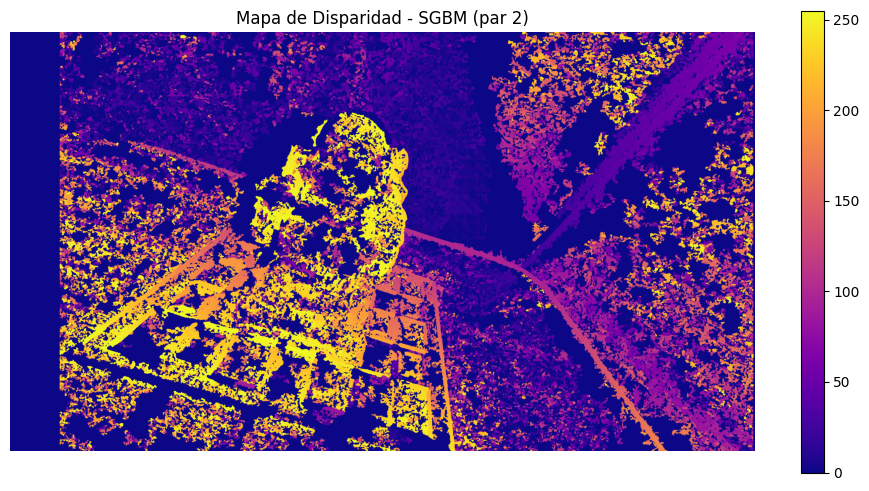

In [8]:
# --- Visualizar uno de ejemplo ---
idx_show = 2
disp_show = cv2.imread(str(out_dir / f"disp_sgbm_{idx_show}.png"), cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12,6))
plt.imshow(disp_show, cmap='plasma')
plt.colorbar()
plt.title(f'Mapa de Disparidad - SGBM (par {idx_show})')
plt.axis('off')
plt.show()


### Cre Stereo

In [9]:
%pip install -qq onnxruntime

Note: you may need to restart the kernel to use updated packages.


In [10]:
width, height = rectL_gray.shape[1], rectL_gray.shape[0]

fx = calib['left_K'][0][0]
fy = calib['left_K'][1][1]
cx0 = calib['left_K'][0][2]
cy0 = calib['left_K'][1][2]

# baseline = np.linalg.norm(calib['T'])  # Distancia entre cámaras

models\crestereo_combined_iter5_720x1280.onnx
→ Procesado par 0: disparidad CRE guardada (raw: .npy, visual: .png)
models\crestereo_combined_iter5_720x1280.onnx
→ Procesado par 1: disparidad CRE guardada (raw: .npy, visual: .png)
models\crestereo_combined_iter5_720x1280.onnx
→ Procesado par 2: disparidad CRE guardada (raw: .npy, visual: .png)
models\crestereo_combined_iter5_720x1280.onnx
→ Procesado par 3: disparidad CRE guardada (raw: .npy, visual: .png)
models\crestereo_combined_iter5_720x1280.onnx
→ Procesado par 4: disparidad CRE guardada (raw: .npy, visual: .png)
models\crestereo_combined_iter5_720x1280.onnx
→ Procesado par 5: disparidad CRE guardada (raw: .npy, visual: .png)
models\crestereo_combined_iter5_720x1280.onnx
→ Procesado par 6: disparidad CRE guardada (raw: .npy, visual: .png)
models\crestereo_combined_iter5_720x1280.onnx
→ Procesado par 7: disparidad CRE guardada (raw: .npy, visual: .png)
models\crestereo_combined_iter5_720x1280.onnx
→ Procesado par 8: disparidad CRE 

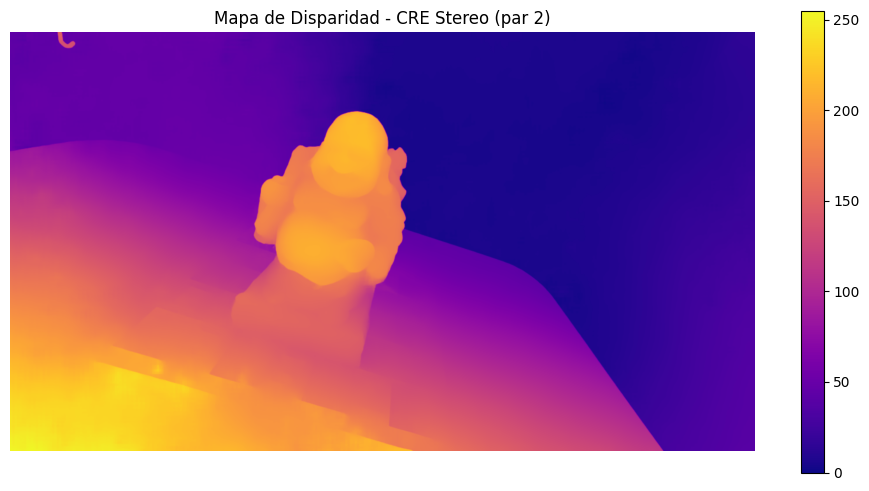

In [31]:
from disparity.methods import Calibration, InputPair, Config
from disparity.method_cre_stereo import CREStereo

# carpeta de salida
out_dir = Path("../out/disparities_cre")
out_dir.mkdir(exist_ok=True)

# baseline entre cámaras
baseline = np.linalg.norm(calib['T'])

# preparar modelo CRE Stereo (se crea una vez y se reutiliza)
models_path = Path("models")
models_path.mkdir(exist_ok=True)

config = Config(models_path=models_path)
cre_stereo = CREStereo(config)

# seteo de parámetros del modelo tal como lo tenías
cre_stereo.parameters['Shape'].set_value('1280x720')

# rango de índices a procesar
indices = range(0, 20)

for i in indices:
    left_path  = f"data/stereo_budha_charuco/captures/left_{i}.jpg"
    right_path = f"data/stereo_budha_charuco/captures/right_{i}.jpg"
    if not Path(left_path).exists() or not Path(right_path).exists():
        print(f"Saltando par {i}: faltan imágenes.")
        continue

    # 1. Rectificación estéreo usando tus mapas
    rectL, rectR = rectify_stereo_pair(left_path, right_path, maps)

    # 2. Pasar a escala de grises (CRE Stereo trabaja con intensidad, igual que SGBM)
    rectL_gray = cv2.cvtColor(rectL, cv2.COLOR_BGR2GRAY)
    rectR_gray = cv2.cvtColor(rectR, cv2.COLOR_BGR2GRAY)

    # 3. Armar la calibración para ESTE par (usa tamaño real de la imagen rectificada)
    height, width = rectL_gray.shape[:2]

    fx  = calib['left_K'][0][0]
    fy  = calib['left_K'][1][1]
    cx0 = calib['left_K'][0][2]
    cy0 = calib['left_K'][1][2]

    # cx1 = cx0 as in tu código original
    calibration = Calibration(**{
        "width": width,
        "height": height,
        "baseline_meters": baseline / 1000,  # mismo que vos
        "fx": fx,
        "fy": fy,
        "cx0": cx0,
        "cx1": cx0,
        "cy": cy0,
        "depth_range": [0.05, 20.0],
        "left_image_rect_normalized": [0, 0, 1, 1]
    })

    # 4. Empaquetar el par para CRE Stereo
    pair = InputPair(
        left_image=rectL_gray,
        right_image=rectR_gray,
        calibration=calibration
    )

    # 5. Correr CRE Stereo para ese par
    disparity_map_cs = cre_stereo.compute_disparity(pair)

    # `disparity_map_cs.disparity_pixels` es la disparidad estimada en píxeles
    disp_cs = disparity_map_cs.disparity_pixels.astype(np.float32)

    # ✅ CAMBIO 1: Guardar disparidad RAW (sin normalizar) en formato .npy
    np.save(str(out_dir / f"disp_cre_{i}.npy"), disp_cs)
    
    # ✅ CAMBIO 2: También guardar versión visual para inspección
    disp_vis = cv2.normalize(disp_cs, None, 0, 255, cv2.NORM_MINMAX)
    disp_vis = np.uint8(disp_vis)
    cv2.imwrite(str(out_dir / f"disp_cre_vis_{i}.png"), disp_vis)  # ⬅️ Cambié el nombre

    print(f"→ Procesado par {i}: disparidad CRE guardada (raw: .npy, visual: .png)")

# 7. Mostrar uno de ejemplo
idx_show = 2
# ✅ CAMBIO 3: Cargar la versión visual (que tiene el sufijo _vis)
disp_show = cv2.imread(str(out_dir / f"disp_cre_vis_{idx_show}.png"), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12, 6))
plt.imshow(disp_show, cmap='plasma')
plt.colorbar()
plt.title(f'Mapa de Disparidad - CRE Stereo (par {idx_show})')
plt.axis('off')
plt.show()

Calculando mapas de profundidad desde los archivos .NPY (raw)...
→ Procesado par 0: mapa de profundidad guardado en ..\out\depth_maps_cre/depth_cre_0.png
→ Procesado par 1: mapa de profundidad guardado en ..\out\depth_maps_cre/depth_cre_1.png
→ Procesado par 2: mapa de profundidad guardado en ..\out\depth_maps_cre/depth_cre_2.png
→ Procesado par 3: mapa de profundidad guardado en ..\out\depth_maps_cre/depth_cre_3.png
→ Procesado par 4: mapa de profundidad guardado en ..\out\depth_maps_cre/depth_cre_4.png
→ Procesado par 5: mapa de profundidad guardado en ..\out\depth_maps_cre/depth_cre_5.png
→ Procesado par 6: mapa de profundidad guardado en ..\out\depth_maps_cre/depth_cre_6.png
→ Procesado par 7: mapa de profundidad guardado en ..\out\depth_maps_cre/depth_cre_7.png
→ Procesado par 8: mapa de profundidad guardado en ..\out\depth_maps_cre/depth_cre_8.png
→ Procesado par 9: mapa de profundidad guardado en ..\out\depth_maps_cre/depth_cre_9.png
→ Procesado par 10: mapa de profundidad guard

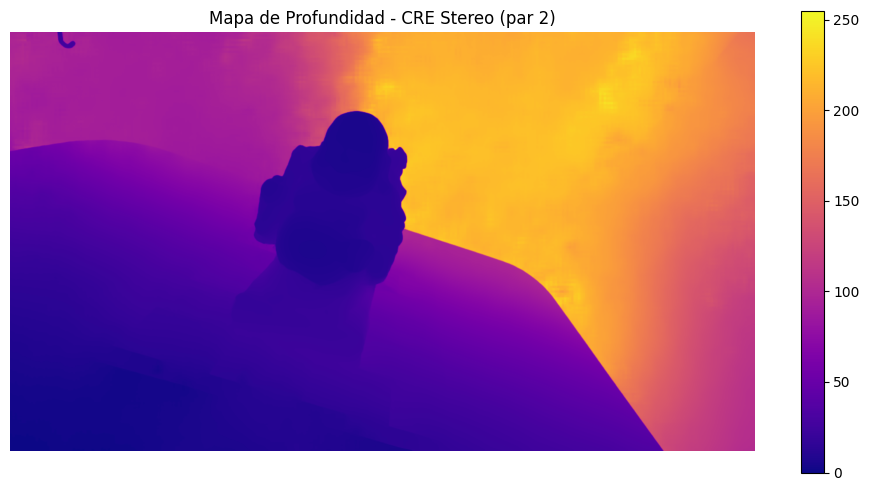

In [32]:
# --- Profundidad (CORREGIDO) ---

# Carpeta de entrada (disparidades CRE - RAW)
disp_dir = Path("../out/disparities_cre") 
# Carpeta de salida (mapas de profundidad visuales)
out_dir = Path("../out/depth_maps_cre")
out_dir.mkdir(exist_ok=True)

# baseline y focal de la cámara izquierda
B = np.linalg.norm(calib['T'])  # baseline
f = calib['left_K'][0][0]       # focal en píxeles

# Rango de imágenes
indices = range(0, 20) # Ahora sí, las 20

print("Calculando mapas de profundidad desde los archivos .NPY (raw)...")

for i in indices:
    # ¡CORRECCIÓN 1! Buscamos el archivo .npy
    disp_path = disp_dir / f"disp_cre_{i}.npy" 
    
    if not disp_path.exists():
        print(f"Saltando par {i}: ¡¡No se encontró el mapa de disparidad RAW (.npy)!!")
        continue

    # ¡CORRECCIÓN 2! Cargamos el .npy (numpy), no la imagen (.png)
    disparity_map = np.load(str(disp_path)).astype(np.float32)

    # ¡CORRECCIÓN 3! Eliminamos la línea de re-escalado.
    # El .npy ya está en píxeles, no necesitamos escalarlo desde 0-255.
    # disparity_map = disparity_map / 255.0 * np.nanmax(disparity_map)  <-- ELIMINADA

    # Calcular profundidad (esto estaba bien)
    depth_map = compute_depth(disparity_map, f, B)

    # Guardar versión visual (normalizada para que se vea bien)
    depth_vis = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    depth_vis = np.uint8(depth_vis)
    cv2.imwrite(str(out_dir / f"depth_cre_{i}.png"), depth_vis)

    print(f"→ Procesado par {i}: mapa de profundidad guardado en {out_dir}/depth_cre_{i}.png")

print("\n¡Mapas de profundidad generados (correctamente)!")

# --- Mostrar uno de ejemplo ---
idx_show = 2
depth_show = cv2.imread(str(out_dir / f"depth_cre_{idx_show}.png"), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12,6))
plt.imshow(depth_show, cmap='plasma')
plt.colorbar()
plt.title(f"Mapa de Profundidad - CRE Stereo (par {idx_show})")
plt.axis('off')
plt.show()

In [33]:
import numpy as np
import cv2
import open3d as o3d
from pathlib import Path
import pickle

# --- 1. Cargar la matriz Q (de la calibración estéreo) ---
with open('data/pkls/stereo_maps.pkl', 'rb') as f:
    maps = pickle.load(f)
Q = maps['Q']

# --- 2. Definir directorios de entrada y salida ---
# Directorio con mapas de disparidad RAW (los .npy)
disp_dir = Path("../out/disparities_cre")

# Directorio con imágenes rectificadas (para sacar el color)
rect_dir = Path('data/stereo_budha_charuco/rectified')

# Directorio de salida para las nubes de puntos LOCALES
pcd_dir = Path("../out/point_clouds_local")
pcd_dir.mkdir(exist_ok=True)

# ¡¡USA LAS 20 VISTAS!!
indices = range(0, 20) 

print("Generando nubes de puntos 3D locales (desde .NPY)...")

for i in indices:
    # --- 3. Cargar los archivos necesarios ---
    # ¡LA FUENTE DE DATOS CORRECTA!
    disp_path = disp_dir / f"disp_cre_{i}.npy"
    rect_left_path = rect_dir / f'rect_left_{i}.jpg'

    if not disp_path.exists():
        print(f"Saltando par {i}: ¡No se encontró el .NPY! (disp_cre_{i}.npy)")
        continue
    if not rect_left_path.exists():
        print(f"Saltando par {i}: ¡No se encontró la imagen rectificada!")
        continue

    # Cargar mapa de disparidad (raw, float)
    disparity_map = np.load(str(disp_path))
    
    # Cargar imagen rectificada (para los colores)
    img_color_rect = cv2.imread(str(rect_left_path))
    
    # --- 4. Reproyectar a 3D ---
    # Esta es la función clave de la consigna
    points_3D = cv2.reprojectImageTo3D(disparity_map, Q)

    # --- 5. Filtrar puntos y obtener colores ---
    mask = (disparity_map > 0) & np.all(np.isfinite(points_3D), axis=2)

    points = points_3D[mask]
    colors_rgb = cv2.cvtColor(img_color_rect, cv2.COLOR_BGR2RGB)
    colors = colors_rgb[mask]

    # --- 6. Crear y guardar la nube de puntos (formato .ply) ---
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors / 255.0) 
    
    output_path = str(pcd_dir / f"pcd_local_{i}.ply")
    o3d.io.write_point_cloud(output_path, pcd)
    
    print(f"→ Procesado par {i}: Nube de puntos local guardada en {output_path}")

print("¡Nubes de puntos locales generadas!")

Generando nubes de puntos 3D locales (desde .NPY)...
→ Procesado par 0: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_0.ply
→ Procesado par 1: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_1.ply
→ Procesado par 2: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_2.ply
→ Procesado par 3: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_3.ply
→ Procesado par 4: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_4.ply
→ Procesado par 5: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_5.ply
→ Procesado par 6: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_6.ply
→ Procesado par 7: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_7.ply
→ Procesado par 8: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_8.ply
→ Procesado par 9: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_9.ply
→ Proce

## Deteccion de Charuco y Pose

In [34]:
import numpy as np
import cv2
import pickle
from pathlib import Path
import aruco # Asumo que sigue importado

# --- 1. Cargar datos de calibración ORIGINALES ---
with open('data/pkls/stereo_calibration.pkl', 'rb') as f:
    calib = pickle.load(f)

# Matriz y distorsión de la CÁMARA IZQUIERDA ORIGINAL
K_left = calib['left_K']
dist_left = calib['left_dist'] # <-- ¡Ahora sí usamos la distorsión real!

# --- 2. Definir el "Mundo" (el tablero ChArUco) ---
# (Esto queda igual que antes)
squares_x = 5
squares_y = 7
square_length = 52.6  # mm
marker_length = 31.3  # mm
use_dict = cv2.aruco.DICT_6X6_250

board = aruco.create_charuco_board(
    squares_x,
    squares_y,
    square_length,
    marker_length,
    use_dict
)

# --- 3. Definir directorios ---
# ¡CORRECCIÓN! Usamos las imágenes ORIGINALES, no las rectificadas
in_dir = Path('data/stereo_budha_charuco/captures')

# ¡ASEGÚRATE DE USAR LAS 20 VISTAS AQUÍ!
indices = range(0, 20) 

poses_mundo = {}

print("Calculando poses de cámara (Cam -> Mundo) usando imágenes ORIGINALES...")

for i in indices:
    # --- 4. Cargar la imagen ORIGINAL IZQUIERDA ---
    left_path = in_dir / f'left_{i}.jpg'
    if not left_path.exists():
        print(f"Saltando par {i}: No se encontró imagen original.")
        continue
    
    img_original_left = cv2.imread(str(left_path))

    # --- 5. Detectar marcadores ChArUco ---
    detection = aruco.detect_charuco_markers(img_original_left, board)
    
    if detection is None:
        print(f"Par {i}: No se detectaron marcadores.")
        poses_mundo[i] = None
        continue

    # --- 6. Estimar la Pose ---
    # ¡CORRECCIÓN! Usamos los intrínsecos ORIGINALES (K y distorsión)
    calibration_original = (K_left, dist_left)

    pose = aruco.estimate_camera_pose_with_homography(
        img_original_left, 
        board, 
        detection, 
        calibration_original
        # Nota: La función '...with_homography' puede tener un parámetro 'undistort=True'
        # que deberíamos activar si la función no lo hace por defecto.
        # Por ahora, probemos así.
    )
    
    if pose is None or not pose[0]:
        print(f"Par {i}: No se pudo estimar la pose.")
        poses_mundo[i] = None
        continue
        
    ok, rvec, tvec = pose
    
    # --- 7. Guardar la pose ---
    poses_mundo[i] = (rvec, tvec)
    print(f"→ Procesado par {i}: Pose guardada.")

print("\nPoses (corregidas) calculadas:")

# --- 8. (Opcional) Visualizar una pose ---
idx_test = 0 
if poses_mundo[idx_test] is not None:
    rvec_test, tvec_test = poses_mundo[idx_test]
    img_test = cv2.imread(str(in_dir / f'left_{idx_test}.jpg'))
    
    # ¡CORRECCIÓN! Dibujamos los ejes usando K_left y dist_left
    cv2.drawFrameAxes(img_test, K_left, dist_left, rvec_test, tvec_test, square_length)
    
    print(f"\nMostrando resultado (original) para par {idx_test}. Cierra la ventana para continuar.")
    cv2.imshow(f'Pose Test (Original) - Par {idx_test}', img_test)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Calculando poses de cámara (Cam -> Mundo) usando imágenes ORIGINALES...
→ Procesado par 0: Pose guardada.
→ Procesado par 1: Pose guardada.
→ Procesado par 2: Pose guardada.
→ Procesado par 3: Pose guardada.
→ Procesado par 4: Pose guardada.
→ Procesado par 5: Pose guardada.
→ Procesado par 6: Pose guardada.
→ Procesado par 7: Pose guardada.
→ Procesado par 8: Pose guardada.
→ Procesado par 9: Pose guardada.
→ Procesado par 10: Pose guardada.
→ Procesado par 11: Pose guardada.
→ Procesado par 12: Pose guardada.
→ Procesado par 13: Pose guardada.
→ Procesado par 14: Pose guardada.
→ Procesado par 15: Pose guardada.
→ Procesado par 16: Pose guardada.
→ Procesado par 17: Pose guardada.
→ Procesado par 18: Pose guardada.
→ Procesado par 19: Pose guardada.

Poses (corregidas) calculadas:

Mostrando resultado (original) para par 0. Cierra la ventana para continuar.


In [35]:
import numpy as np
import cv2
import open3d as o3d
from pathlib import Path
import pickle

# --- 1. Cargar la matriz Q (de la calibración estéreo) ---
with open('data/pkls/stereo_maps.pkl', 'rb') as f:
    maps = pickle.load(f)

# Extraer la matriz Q que necesitamos
Q = maps['Q']

# --- 2. Definir directorios de entrada y salida ---
# Directorio con mapas de disparidad RAW (los .npy)
disp_dir = Path("../out/disparities_cre")

# Directorio con imágenes rectificadas (para sacar el color)
rect_dir = Path('data/stereo_budha_charuco/rectified')

# Directorio de salida para las nubes de puntos LOCALES
pcd_dir = Path("../out/point_clouds_local")
pcd_dir.mkdir(exist_ok=True)

indices = range(0, 20) # Mismo rango que usaste

print("Generando nubes de puntos 3D locales...")

for i in indices:
    # --- 3. Cargar los archivos necesarios ---
    disp_path = disp_dir / f"disp_cre_{i}.npy"
    rect_left_path = rect_dir / f'rect_left_{i}.jpg'

    if not disp_path.exists() or not rect_left_path.exists():
        print(f"Saltando par {i}: Faltan archivos.")
        continue

    # Cargar mapa de disparidad (raw, float)
    disparity_map = np.load(str(disp_path))
    
    # Cargar imagen rectificada (para los colores)
    img_color_rect = cv2.imread(str(rect_left_path))
    
    # --- 4. Reproyectar a 3D ---
    # Usamos cv.reprojectImageTo3D. Esto crea una imagen (H, W, 3)
    # donde cada "píxel" es una coordenada (X, Y, Z)
    points_3D = cv2.reprojectImageTo3D(disparity_map, Q)

    # --- 5. Filtrar puntos y obtener colores ---
    
    # Crear una máscara para puntos válidos
    # La disparidad debe ser positiva (mayor que el mínimo)
    # Los puntos 3D deben ser finitos (reprojectImageTo3D crea 'inf' para disparidades 0)
    mask = (disparity_map > disparity_map.min()) & np.all(np.isfinite(points_3D), axis=2)

    # Aplicar la máscara para obtener una lista plana de puntos (N, 3)
    points = points_3D[mask]
    
    # Obtener los colores correspondientes de la imagen rectificada
    colors_rgb = cv2.cvtColor(img_color_rect, cv2.COLOR_BGR2RGB)
    colors = colors_rgb[mask]

    # --- 6. Crear y guardar la nube de puntos (formato .ply) ---
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors / 255.0) # Colores van de 0.0 a 1.0
    
    # Guardar el archivo .ply
    output_path = str(pcd_dir / f"pcd_local_{i}.ply")
    o3d.io.write_point_cloud(output_path, pcd)
    
    print(f"→ Procesado par {i}: Nube de puntos local guardada en {output_path}")

print("¡Nubes de puntos locales generadas!")

Generando nubes de puntos 3D locales...
→ Procesado par 0: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_0.ply
→ Procesado par 1: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_1.ply
→ Procesado par 2: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_2.ply
→ Procesado par 3: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_3.ply
→ Procesado par 4: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_4.ply
→ Procesado par 5: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_5.ply
→ Procesado par 6: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_6.ply
→ Procesado par 7: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_7.ply
→ Procesado par 8: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_8.ply
→ Procesado par 9: Nube de puntos local guardada en ..\out\point_clouds_local\pcd_local_9.ply
→ Procesado par 10: 

In [36]:
import open3d as o3d
from pathlib import Path

# Directorio donde guardaste las nubes locales
pcd_dir = Path("../out/point_clouds_local")

# Elegimos un índice para revisar, por ejemplo el 2
idx_test = 2
pcd_path = str(pcd_dir / f"pcd_local_{idx_test}.ply")

try:
    print(f"Cargando {pcd_path} para visualización...")
    pcd_local = o3d.io.read_point_cloud(pcd_path)
    
    if not pcd_local.has_points():
        print("¡Error! El archivo .ply está vacío o no se pudo leer.")
    else:
        print("Mostrando nube de puntos local. Cierra la ventana para continuar...")
        # Visualizar la nube de puntos
        o3d.visualization.draw_geometries(
            [pcd_local],
            window_name=f"Vista Local - Par {idx_test}",
            width=800,
            height=600
        )
        
except FileNotFoundError:
    print(f"No se encontró el archivo: {pcd_path}")

Cargando ..\out\point_clouds_local\pcd_local_2.ply para visualización...
Mostrando nube de puntos local. Cierra la ventana para continuar...


## Proyeccion

In [37]:
import open3d as o3d
import numpy as np
import cv2
from pathlib import Path

# Directorio de nubes locales
pcd_dir = Path("../out/point_clouds_local")
indices = range(0, 20)

# --- 1. Crear la nube de puntos "Mundial" ---
pcd_mundo_final = o3d.geometry.PointCloud()

# (Sugerencia de la consigna) Crear un frame de coordenadas para el "Mundo" 
world_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=100.0,  # 100 mm (10 cm) de tamaño para los ejes
    origin=[0, 0, 0] # Origen en el (0,0,0) del tablero
)

# ¡¡AQUÍ ESTABA EL ERROR!! La siguiente línea se elimina.
# pcd_mundo_final += world_frame  <--- ESTA LÍNEA LA BORRAMOS

print("Transformando y uniendo todas las nubes de puntos...")

# --- 2. Iterar por cada par ---
for i in indices:
    
    # --- 3. Cargar la pose (rvec, tvec) ---
    if i not in poses_mundo or poses_mundo[i] is None:
        print(f"Saltando par {i}: No se encontró pose.")
        continue
    
    rvec, tvec = poses_mundo[i]
    
    # --- 4. Cargar la nube de puntos LOCAL ---
    pcd_path = str(pcd_dir / f"pcd_local_{i}.ply")
    try:
        pcd_local = o3d.io.read_point_cloud(pcd_path)
        if not pcd_local.has_points():
            print(f"Saltando par {i}: Nube de puntos local está vacía.")
            continue
    except FileNotFoundError:
        print(f"Saltando par {i}: No se encontró el archivo {pcd_path}.")
        continue

    # --- 5. Calcular la Matriz de Transformación (Cam -> Mundo) ---
    c_R_o, _ = cv2.Rodrigues(rvec)
    cTo = np.identity(4)
    cTo[0:3, 0:3] = c_R_o
    cTo[0:3, 3:4] = tvec
    oTc = np.linalg.inv(cTo) # Inversa para pasar de Cam -> Mundo

    # --- 6. Aplicar la transformación a la nube local ---
    pcd_local.transform(oTc)
    
    # --- 7. Añadir la nube transformada a la nube final ---
    pcd_mundo_final += pcd_local
    
    print(f"→ Procesado par {i}: Nube transformada y añadida.")

print("¡Unión final completada!")

# --- 8. Filtrar Outliers (Sugerencia 5.a de la consigna)  ---
print("Filtrando outliers (puede tardar un momento)...")
pcd_filtrada, ind = pcd_mundo_final.remove_statistical_outlier(
    nb_neighbors=20,
    std_ratio=2.0
)
print(f"¡Filtrado completado! Se removieron {len(pcd_mundo_final.points) - len(pcd_filtrada.points)} puntos.")


# --- 9. Visualizar la Reconstrucción 3D Completa ---
#
# ¡¡AQUÍ ESTÁ LA CORRECCIÓN!!
# Pasamos una LISTA con las dos geometrías que queremos ver:
# la nube filtrada Y los ejes del mundo.
#
print("Mostrando reconstrucción 3D FINAL (filtrada) junto a los ejes del mundo.")
o3d.visualization.draw_geometries(
    [pcd_filtrada, world_frame], # <-- Esta es la lista corregida
    window_name="Reconstrucción 3D Final - Buda",
    width=1024,
    height=768
)

# --- 10. (Opcional) Guardar la nube de puntos final ---
output_final_path = "../out/pcd_final_filtrada.ply"
o3d.io.write_point_cloud(output_final_path, pcd_filtrada)
print(f"Nube de puntos final guardada en: {output_final_path}")

Transformando y uniendo todas las nubes de puntos...
→ Procesado par 0: Nube transformada y añadida.
→ Procesado par 1: Nube transformada y añadida.
→ Procesado par 2: Nube transformada y añadida.
→ Procesado par 3: Nube transformada y añadida.
→ Procesado par 4: Nube transformada y añadida.
→ Procesado par 5: Nube transformada y añadida.
→ Procesado par 6: Nube transformada y añadida.
→ Procesado par 7: Nube transformada y añadida.
→ Procesado par 8: Nube transformada y añadida.
→ Procesado par 9: Nube transformada y añadida.
→ Procesado par 10: Nube transformada y añadida.
→ Procesado par 11: Nube transformada y añadida.
→ Procesado par 12: Nube transformada y añadida.
→ Procesado par 13: Nube transformada y añadida.
→ Procesado par 14: Nube transformada y añadida.
→ Procesado par 15: Nube transformada y añadida.
→ Procesado par 16: Nube transformada y añadida.
→ Procesado par 17: Nube transformada y añadida.
→ Procesado par 18: Nube transformada y añadida.
→ Procesado par 19: Nube t

In [38]:
# --- 8. (MODIFICADO) Filtrado Geométrico (Bounding Box) ---

print(f"Puntos antes del filtrado: {len(pcd_mundo_final.points)}")

# --- ¡AQUÍ ESTÁ LA CORRECCIÓN! ---
# Probamos invertir el eje Z (profundidad)
#
# Valor original: [130, 180, 150]
# Intento anterior: [130, -180, 150] (Incorrecto)
#
# Nuevo intento:
center_box = [130, 180, -150]  # <-- CAMBIAMOS A -150
#
# Es posible que tengas que sintonizar este -150 (ej. -140, -160)
extent_box = [200, 300, 250]  
R_box = np.identity(3)       

# Creamos la Bounding Box
bbox = o3d.geometry.OrientedBoundingBox(center_box, R_box, extent_box)
bbox.color = [1, 0, 0] # Color rojo

# Visualiza la caja junto a la nube RUIDOSA para sintonizar
print("Visualizando la Bounding Box (caja roja) con la nube completa...")
print("Cierra esta ventana para continuar con el filtrado.")
o3d.visualization.draw_geometries([pcd_mundo_final, world_frame, bbox])

# --- 9. Aplicar el filtro Bounding Box ---
print("Aplicando filtro de Bounding Box...")
indices_in_box = bbox.get_point_indices_within_bounding_box(pcd_mundo_final.points)
pcd_recortada = pcd_mundo_final.select_by_index(indices_in_box)

print(f"Puntos después del Bounding Box: {len(pcd_recortada.points)}")

# --- 10. Filtrar Outliers ---
print("Filtrando outliers de la nube recortada...")
pcd_filtrada_final, ind = pcd_recortada.remove_statistical_outlier(
    nb_neighbors=20,
    std_ratio=2.0
)
print(f"Puntos finales después del filtro de outliers: {len(pcd_filtrada_final.points)}")

# --- 11. Visualizar la Reconstrucción 3D FINAL ---
print("Mostrando reconstrucción 3D FINAL (Recortada y Filtrada).")
o3d.visualization.draw_geometries(
    [pcd_filtrada_final, world_frame, bbox], 
    window_name="Reconstrucción 3D Final - Buda (Filtrada)",
    width=1024,
    height=768
)

# --- 12. Guardar la nube de puntos final ---
output_final_path = "../out/pcd_final_filtrada.ply"
o3d.io.write_point_cloud(output_final_path, pcd_filtrada_final)
print(f"Nube de puntos final guardada en: {output_final_path}")

Puntos antes del filtrado: 41471980
Visualizando la Bounding Box (caja roja) con la nube completa...
Cierra esta ventana para continuar con el filtrado.
Aplicando filtro de Bounding Box...
Puntos después del Bounding Box: 2420672
Filtrando outliers de la nube recortada...
Puntos finales después del filtro de outliers: 2372671
Mostrando reconstrucción 3D FINAL (Recortada y Filtrada).
Nube de puntos final guardada en: ../out/pcd_final_filtrada.ply


In [39]:
import numpy as np
import pickle

# Cargar calibración
with open('data/pkls/stereo_calibration.pkl', 'rb') as f:
    calib = pickle.load(f)

with open('data/pkls/stereo_maps.pkl', 'rb') as f:
    maps = pickle.load(f)

baseline = np.linalg.norm(calib['T'])
fx = calib['left_K'][0][0]
Q = maps['Q']

print("="*50)
print("DIAGNÓSTICO DE CALIBRACIÓN")
print("="*50)
print(f"Baseline: {baseline:.2f} mm")
print(f"Focal (fx): {fx:.2f} px")
print(f"Q[3,2] (debe ser fx*baseline): {Q[3,2]:.2f}")
print(f"Calculado (fx*baseline): {fx * baseline:.2f}")
print(f"\nMatriz Q completa:")
print(Q)
print("="*50)

DIAGNÓSTICO DE CALIBRACIÓN
Baseline: 59.83 mm
Focal (fx): 598.41 px
Q[3,2] (debe ser fx*baseline): 0.02
Calculado (fx*baseline): 35804.06

Matriz Q completa:
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -9.50835083e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -5.34347099e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.99158755e+02]
 [ 0.00000000e+00  0.00000000e+00  1.67133899e-02 -0.00000000e+00]]


In [40]:
import open3d as o3d
from pathlib import Path

# Cargar UNA nube local
pcd_test = o3d.io.read_point_cloud("../out/point_clouds_local/pcd_local_0.ply")

print(f"Puntos en nube local 0: {len(pcd_test.points)}")

# Obtener estadísticas
aabb = pcd_test.get_axis_aligned_bounding_box()
print(f"Centro de la nube: {aabb.get_center()}")
print(f"Tamaño (extent): {aabb.get_extent()}")
print(f"Min: {aabb.min_bound}")
print(f"Max: {aabb.max_bound}")

# Visualizar
world_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=100.0,
    origin=[0, 0, 0]
)

print("\nVisualizando nube local 0...")
print("¿Se ve el Buda? ¿Tiene forma reconocible?")
o3d.visualization.draw_geometries(
    [pcd_test, world_frame],
    window_name="Nube Local 0 - ¿Se ve bien?"
)

Puntos en nube local 0: 2073599
Centro de la nube: [ 290.54632568 -466.93728638 1424.65420532]
Tamaño (extent): [3246.05603027 2725.31243896 2481.24188232]
Min: [-1332.48168945 -1829.59350586   184.03326416]
Max: [1913.57434082  895.71893311 2665.27514648]

Visualizando nube local 0...
¿Se ve el Buda? ¿Tiene forma reconocible?


In [41]:
import cv2
import numpy as np
from pathlib import Path

# Cargar una imagen ORIGINAL
img_test = cv2.imread('data/stereo_budha_charuco/captures/left_0.jpg')

# Verificar que tengas la pose
if 0 in poses_mundo and poses_mundo[0] is not None:
    rvec, tvec = poses_mundo[0]
    
    print(f"Pose 0:")
    print(f"  rvec: {rvec.ravel()}")
    print(f"  tvec: {tvec.ravel()} mm")
    
    # Dibujar ejes
    K_left = calib['left_K']
    dist_left = calib['left_dist']
    
    cv2.drawFrameAxes(img_test, K_left, dist_left, rvec, tvec, 52.6)
    
    # Mostrar
    img_small = cv2.resize(img_test, (0, 0), fx=0.5, fy=0.5)
    cv2.imshow('Pose 0 - Los ejes deben estar sobre el tablero', img_small)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    print("\n¿Los ejes (RGB) están sobre el tablero ChArUco?")
    print("Rojo=X, Verde=Y, Azul=Z")
else:
    print("ERROR: No hay pose para el par 0")

Pose 0:
  rvec: [-1.02369816  0.29669801  1.37949038]
  tvec: [ 85.2368553   25.58138256 533.83449463] mm

¿Los ejes (RGB) están sobre el tablero ChArUco?
Rojo=X, Verde=Y, Azul=Z


In [42]:
import open3d as o3d
import numpy as np
import cv2
from pathlib import Path

# Directorio de nubes locales
pcd_dir = Path("../out/point_clouds_local")
indices = range(0, 20)

# Crear nube mundial vacía
pcd_mundo_completa = o3d.geometry.PointCloud()

# Frame del mundo
world_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=100.0,
    origin=[0, 0, 0]
)

print("Uniendo todas las nubes SIN FILTRAR...")

for i in indices:
    # Verificar que exista la pose
    if i not in poses_mundo or poses_mundo[i] is None:
        print(f"  Saltando par {i}: No hay pose")
        continue
    
    # Cargar nube local
    pcd_path = str(pcd_dir / f"pcd_local_{i}.ply")
    try:
        pcd_local = o3d.io.read_point_cloud(pcd_path)
        if not pcd_local.has_points():
            print(f"  Saltando par {i}: Nube vacía")
            continue
    except:
        print(f"  Saltando par {i}: No se pudo cargar")
        continue
    
    # Obtener pose
    rvec, tvec = poses_mundo[i]
    
    # Calcular transformación
    c_R_o, _ = cv2.Rodrigues(rvec)
    cTo = np.identity(4)
    cTo[0:3, 0:3] = c_R_o
    cTo[0:3, 3:4] = tvec
    oTc = np.linalg.inv(cTo)
    
    # Transformar
    pcd_local.transform(oTc)
    
    # Añadir a la nube mundial
    pcd_mundo_completa += pcd_local
    
    print(f"  ✓ Par {i}: {len(pcd_local.points)} puntos añadidos")

print(f"\nTotal de puntos: {len(pcd_mundo_completa.points)}")

# Calcular límites
aabb = pcd_mundo_completa.get_axis_aligned_bounding_box()
center = aabb.get_center()
extent = aabb.get_extent()

print(f"\nEstadísticas de la nube completa:")
print(f"  Centro: {center}")
print(f"  Tamaño (extent): {extent}")
print(f"  Min: {aabb.min_bound}")
print(f"  Max: {aabb.max_bound}")

# Visualizar TODO sin filtrar
print("\nVisualizando reconstrucción COMPLETA (sin filtros)...")
print("Observa dónde está el Buda y dónde está el ruido")
o3d.visualization.draw_geometries(
    [pcd_mundo_completa, world_frame],
    window_name="Reconstrucción COMPLETA - Sin Filtros",
    width=1280,
    height=720
)

Uniendo todas las nubes SIN FILTRAR...
  ✓ Par 0: 2073599 puntos añadidos
  ✓ Par 1: 2073599 puntos añadidos
  ✓ Par 2: 2073599 puntos añadidos
  ✓ Par 3: 2073599 puntos añadidos
  ✓ Par 4: 2073599 puntos añadidos
  ✓ Par 5: 2073599 puntos añadidos
  ✓ Par 6: 2073599 puntos añadidos
  ✓ Par 7: 2073599 puntos añadidos
  ✓ Par 8: 2073599 puntos añadidos
  ✓ Par 9: 2073599 puntos añadidos
  ✓ Par 10: 2073599 puntos añadidos
  ✓ Par 11: 2073599 puntos añadidos
  ✓ Par 12: 2073599 puntos añadidos
  ✓ Par 13: 2073599 puntos añadidos
  ✓ Par 14: 2073599 puntos añadidos
  ✓ Par 15: 2073599 puntos añadidos
  ✓ Par 16: 2073599 puntos añadidos
  ✓ Par 17: 2073599 puntos añadidos
  ✓ Par 18: 2073599 puntos añadidos
  ✓ Par 19: 2073599 puntos añadidos

Total de puntos: 41471980

Estadísticas de la nube completa:
  Centro: [135431.44175811   2330.43982002  33636.75536255]
  Tamaño (extent): [477225.72187242  20750.57902572 119255.09252483]
  Min: [-103181.4191781    -8044.84969284  -25990.79089986]


In [ ]:
# AJUSTA ESTOS VALORES según lo que viste en el Paso 4
# Ejemplo: si el centro era [120, 150, -200] y extent [300, 400, 350]

center_box = aabb.get_center()  # Usar el centro automático
extent_box = aabb.get_extent() * 0.8  # 80% del tamaño total (para quitar bordes)

# O manualmente (si viste que el Buda está en otra zona):
# center_box = [100, 150, -180]  # AJUSTA según lo que viste
# extent_box = [250, 350, 300]   # AJUSTA según lo que viste

R_box = np.identity(3)

# Crear bounding box
bbox = o3d.geometry.OrientedBoundingBox(center_box, R_box, extent_box)
bbox.color = [1, 0, 0]

# Visualizar la caja ANTES de filtrar
print("\nVisualizando Bounding Box (caja roja)...")
print("¿La caja contiene el Buda y excluye el ruido?")
o3d.visualization.draw_geometries(
    [pcd_mundo_completa, world_frame, bbox],
    window_name="Ajustar Bounding Box"
)

# Si la caja se ve bien, aplicar filtro
print("\n¿Se ve bien la caja? (s/n)")
respuesta = input()

if respuesta.lower() == 's':
    # Aplicar filtro de bounding box
    indices_in_box = bbox.get_point_indices_within_bounding_box(pcd_mundo_completa.points)
    pcd_recortada = pcd_mundo_completa.select_by_index(indices_in_box)
    print(f"Puntos después de recorte: {len(pcd_recortada.points)}")
    
    # Filtrar outliers (suave)
    print("Filtrando outliers...")
    pcd_filtrada, ind = pcd_recortada.remove_statistical_outlier(
        nb_neighbors=30,
        std_ratio=3.0
    )
    print(f"Puntos finales: {len(pcd_filtrada.points)}")
    
    # Visualizar resultado final
    print("\nVisualizando resultado FINAL...")
    o3d.visualization.draw_geometries(
        [pcd_filtrada, world_frame],
        window_name="Reconstrucción FINAL - Buda Filtrado"
    )
    
    # Guardar
    output_path = "../out/pcd_final_filtrada_v2.ply"
    o3d.io.write_point_cloud(output_path, pcd_filtrada)
    print(f"\n✓ Guardado en: {output_path}")
else:
    print("\nAjusta manualmente center_box y extent_box y vuelve a ejecutar.")